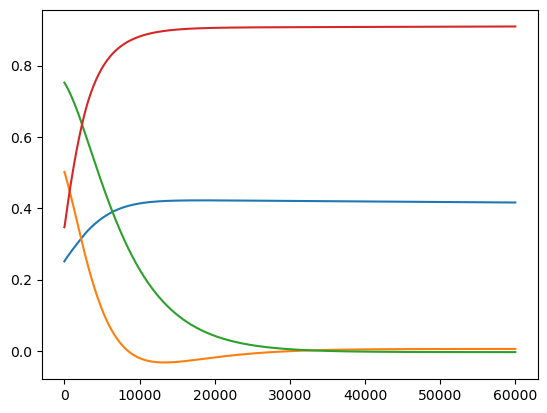

In [1]:
#Spacecraft attitude control using magnetic actuators


import ahrs
import datetime
import numpy as np
import transforms3d as tf
import matplotlib.pyplot as plt
# Constant Definition
N = 60000
J = (10** -9 )* np.array( [[10842134.25,3186913.98,2300355.25],[3186913.98,6296514.94,4414409.57],[2300355.25,4414409.57,9345370.68]])
J = np.diag([27,17,25])
epsilon = 0.001
kp = .0085
kd = 0.
kv = .001
dt = 0.001

# Variable Definition
q = np.zeros([N,4,1])
w = np.zeros([N,3,1])
t = np.zeros([N,1,1])

q[0,:,0] = [0.2506910387,0.5013820774,0.7520731161,0.3466353178]
w[0,:,0] = 0.0002*np.array([3.8,-0.2,1.2])


def A(q):
    return [[q[0]**2 - q[1]**2 - q[2]**2+ q[3]**2,2.*(q[0]*q[1]+q[2]*q[3])                  ,2.*(q[0]*q[2]-q[1]*q[3])],
            [2.*(q[0]*q[1]-q[2]*q[3])                 ,-q[0]**2 + q[1]**2 - q[2]**2+ q[3]**2,2.*(q[1]*q[2]+q[0]*q[3])],
            [2.*(q[0]*q[2]+q[1]*q[3])                 ,2.*(q[1]*q[2]-q[0]*q[3]),-q[0]**2 - q[1]**2 + q[2]**2+ q[3]**2]]

def W(q):
    return np.array([[q[3],-q[2],q[1]],[q[2],q[3],-q[0]],[-q[1],q[0],q[3]],[-q[0],-q[1],-q[2]]])

def S(w):
    return np.array([[0,w[2],-w[1]],[-w[2],0,w[0]],[w[1],-w[0],0]])

def body_to_eci_quaternion(body_vector, quaternion):
    rotation_matrix = tf.quaternions.quat2mat(quaternion)
    eci_vector = np.dot(rotation_matrix, body_vector)
    return eci_vector



wmm = ahrs.utils.WMM()              # Create today's magnetic model
wmm.magnetic_field(10.0, 20.0, height=450, date=datetime.date(2017, 5, 12))

#np.cross(B, w[i,:,0])

for i in range (N - 1):
    #u = - epsilon**2 * kp * q[i,0:3,0] - epsilon * kv * (J @ w[i,:,0])
    u = - kp * np.linalg.inv(J) @ q[i,0:3,0] - kv * ( w[i,:,0])
    #if (i>1):
    #    u = u - epsilon**2 * kd * (q[i,0:3,0] - q[i-1,0:3,0])
    B = np.array([wmm.X,wmm.Y,wmm.Z])
    #B = np.array([-14305.00928,-43991.29212,-10640.60109]);
    Bbar = A(q[i,:,0])@B
    
    mcoil =(S(Bbar).T@u)/np.abs((B))
    #mcoil = -0.00001*S(w[i,:,0])@Bbar
    #mcoil = np.array([1,2,3]) 

    Tcoil = S(Bbar)@mcoil


    # Calculate differentiate of the w and q
    wdot  = np.linalg.inv(J)@S(w[i,:,0])@J@w[i,:,0] + np.linalg.inv(J)@Tcoil
    qdot = np.multiply(W(q[i,:,0])@w[i,:,0],0.5)

    # Updating w and q
    w[i+1,:,0] = w[i,:,0] + dt * wdot
    q[i+1,:,0] = q[i,:,0] + dt * qdot


plt.plot(q[:,0,0])
plt.plot(q[:,1,0])
plt.plot(q[:,2,0])
plt.plot(q[:,3,0])

In [12]:
import numpy as np

a = np.zeros([4,5])
I = np.array([[10842134.25,3186913.98,2300355.25],[3186913.98,6296514.94,4414409.57],[2300355.25,4414409.57,934537068]])
I = np.multiply(I,10**(-9))
print(I)
m = np.multiply(np.eye(3),0.131) #Dipole Momentum
print(m)

[[0.01084213 0.00318691 0.00230036]
 [0.00318691 0.00629651 0.00441441]
 [0.00230036 0.00441441 0.93453707]]
[[0.131 0.    0.   ]
 [0.    0.131 0.   ]
 [0.    0.    0.131]]


In [49]:
import ppigrf
from datetime import datetime
lon = 5.32415  # degrees east
lat = 60.39299 # degrees north
h   = 100        # kilometers above sea level
date = datetime(2021, 3, 28)

Be, Bn, Bu = ppigrf.igrf(lon, lat, h, date) # returns east, north, up

In [52]:
N = 10000
ep_state = np.zeros([3,1,N])
q0_state = np.zeros([1,1,N])
omega_state = np.zeros([3,1,N])


#Based on this document https://ahrs.readthedocs.io/en/latest/filters/ekf.html
CqT = [[0.5 - ep_state[1,0,i]**2 - ep_state[2,0,i]**2, q0_state[0,0,i]*ep_state[2,0,i] + ep_state[0,0,i]*ep_state[1,0,i],ep_state[0,0,i]*ep_state[2,0,i] - ep_state[1,0,i]*q0_state[0,0,i]]
,[-q0_state[0,0,i]*ep_state[2,0,i] + ep_state[0,0,i]*ep_state[1,0,i],0.5 - ep_state[0,0,i]**2 - ep_state[2,0,i]**2,q0_state[0,0,i]*ep_state[0,0,i] + ep_state[1,0,i]*ep_state[2,0,i]]
,[ep_state[0,0,i]*ep_state[2,0,i] + ep_state[1,0,i]*q0_state[0,0,i], - q0_state[0,0,i]*ep_state[0,0,i] + ep_state[1,0,i]*ep_state[2,0,i],0.5 - ep_state[0,0,i]**2 - ep_state[1,0,i]**2]]

## It is on nT but I am not sure
B = np.array([[Be[0,0]],[Bn[0,0]],[Bu[0,0]]])

## It is multiply with 2 because we need to have a identity if q0,q1,q2,q3 = 0
m = [[0,0.131,0.131]]
#m = [[0.131,0,0.131]]
Torque = np.cross(m, (CqT@B*2*10**(-4)).T)

epdot = 0.5*(np.dot(q0_state[0,0,i],omega_state[:,0,i]) - np.cross(omega_state[:,0,i],ep_state[:,0,i]))
q0dot = -0.5*ep_state[:,0,i].T@omega_state[:,0,i]
omegadot = np.linalg.inv(I)@(np.cross(-omega_state[:,0,i],I@omega_state[:,0,i])+Torque[0])

In [53]:
print(omegadot,epdot,q0dot)

[-8.74210888e+01  4.50872997e+01 -3.43320472e-03] [0. 0. 0.] 0.0


In [48]:
np.linalg.inv(I)

array([[ 1.08352845e+02, -5.48362519e+01, -7.68333444e-03],
       [-5.48362519e+01,  1.87097775e+02, -7.48802133e-01],
       [-7.68333444e-03, -7.48802133e-01,  1.07360449e+00]])

In [50]:
I@omega_state[:,0,i]

array([0., 0., 0.])

In [42]:
np.cross(omega_state[:,0,i],ep_state[:,0,i])

array([0., 0., 0.])

In [14]:
import ppigrf
from datetime import datetime
lon = 5.32415  # degrees east
lat = 60.39299 # degrees north
h   = 0        # kilometers above sea level
date = datetime(2021, 3, 28)

Be, Bn, Bu = ppigrf.igrf(lon, lat, h, date) # returns east, north, up

In [25]:
print(Be[0,0], Bn, Bu)
B = np.array([[Be[0,0]],[Bn[0,0]],[Bu[0,0]]])
print(B)

469.77963061114497 [[15001.38754573]] [[-49032.67695955]]
[[   469.77963061]
 [ 15001.38754573]
 [-49032.67695955]]


In [29]:
i = 0

#Based on this document https://ahrs.readthedocs.io/en/latest/filters/ekf.html
CqT = [[0.5 - ep_state[1,0,i]**2 - ep_state[2,0,i]**2, q0_state[0,0,i]*ep_state[2,0,i] + ep_state[0,0,i]*ep_state[1,0,i],ep_state[0,0,i]*ep_state[2,0,i] - ep_state[1,0,i]*q0_state[0,0,i]]
,[-q0_state[0,0,i]*ep_state[2,0,i] + ep_state[0,0,i]*ep_state[1,0,i],0.5 - ep_state[0,0,i]**2 - ep_state[2,0,i]**2,q0_state[0,0,i]*ep_state[0,0,i] + ep_state[1,0,i]*ep_state[2,0,i]]
,[ep_state[0,0,i]*ep_state[2,0,i] + ep_state[1,0,i]*q0_state[0,0,i], - q0_state[0,0,i]*ep_state[0,0,i] + ep_state[1,0,i]*ep_state[2,0,i],0.5 - ep_state[0,0,i]**2 - ep_state[1,0,i]**2]]

## It is on nT but I am not sure
B = np.array([[Be[0,0]],[Bn[0,0]],[Bu[0,0]]])

## It is multiply with 2 because we need to have a identity if q0,q1,q2,q3 = 0
print(CqT@B*2)

[[   469.77963061]
 [ 15001.38754573]
 [-49032.67695955]]


In [40]:
m = [[0.131,0.131,0]]
m = [[0,0.131,0.131]]
#m = [[0.131,0,0.131]]
Torque = np.cross(m, (CqT@B*2*10**(-4)).T)
print(Torque)

[[-0.83884625  0.00615411 -0.00615411]]
